In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices

# Additional Linear Modeling Schemes

Previously, we used primarily Ordinary Least Squares, which is helpful because it can help tell us if the noise on the data (the residuals of the "smooth" model) is normal.

Once we have a regression model, we can run a few diagnostics and tests, many of which are already run by `statsmodels` as part of the `.summary()` function.  There are a few more diagnostics available as well, see: https://www.statsmodels.org/stable/examples/notebooks/generated/regression_diagnostics.html

However, sometimes our data/residuals are not normal.  See: https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity

Sometimes, there is a correlation between the residuals, which happens quite often in time-series data. In this case, we may want to use Generalized Least Squares.

Other times, we might have too much data to really thrown out any outliers, and thus need to create a robust regression model using either Robust Least Squares or RANSAC.  RANSAC is actually used quite often in computer vision!

We'll explore all of these today using `../datasets_as/fat.csv`!

## `statsmodels` design matrices API

First, a little bit more about why we have `endog` and `exog`, and why we had the "machine learning" API.

For reference: https://www.statsmodels.org/stable/gettingstarted.html#design-matrices-endog-exog

Conveniently, this will help us as we explore our other regression modeling library, `sklearn` (scikit-learn)!

Set up the X (exog) and y (endog) matrices, then double-check that it works with OLS:

In [2]:
df_wind = pd.read_excel(
    "../datasets_ml/GECAD_renewable_energy_lab _Wind_power_data.xlsx",
    sheet_name="Wind speed and Power")

df_wind.drop(columns="Year", inplace=True)

df_wind["Time (s)"] = ((df_wind["Month"] - 1) * 2628000 + 
                       (df_wind["Day"] - 1) * 86400 + 
                       df_wind["Hour"] * 3600 + 
                       df_wind["Minute"] * 60)

df_wind_good = df_wind[(df_wind["Wind speed (m/s)"] < 11.6) & (df_wind["Power (W)"] > 0)].copy()
df_wind_good.dropna(inplace=True)

df_wind_good_renamed = df_wind_good.rename(
    columns={
        "Wind speed (m/s)": "Wind_speed_mps",
        "Power (W)": "Power_W",
        "Time (s)": "Time_s"
    })

df_wind_good_renamed.head()

,Month,Day,Hour,Minute,Wind_speed_mps,Power_W,Time_s
0,1,1,0,0,5.26,103.349282,0
1,1,1,0,10,5.50,114.832536,600
2,1,1,0,20,4.76,79.425837,1200
3,1,1,0,30,4.94,88.038278,1800
4,1,1,0,40,4.42,63.157895,2400


In [7]:
wind_turbine_y, wind_turbine_X = dmatrices(
    'Power_W ~ Time_s + Wind_speed_mps + 1',
    data=df_wind_good_renamed,
    return_type='dataframe')

In [8]:
import statsmodels.regression.linear_model as slm

model_wind_good = slm.OLS(wind_turbine_y, wind_turbine_X)
model_wind_good_results = model_wind_good.fit()
model_wind_good_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Power_W   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.676e+33
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:57:52   Log-Likelihood:             7.9092e+05
No. Observations:               28721   AIC:                        -1.582e+06
Df Residuals:                   28718   BIC:                        -1.582e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -148.3254   5.43e-15  -2.73e+16      0.000    -148.325    -148.325
Time_s          1.143e-20   1.87e-22     61.128      0.000    1.11e-20    1.18e-20
Wind_speed_mps    47.8469   6.55e-16    7.3e+16      0.000      47.847      47.847
==============================================================================
Omnibus:                      263.998   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.838
Skew:                           0.129   Prob(JB):                     7.39e-46
Kurtosis:                       2.673   Cond. No.                     5.86e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Introducing `sklearn`

scikit-learn is a library full of machine learning schemes!  We don't cover the workings of the algorithms per se here, but we will walk through what each scheme does aim to minimize.

See: https://scikit-learn.org/stable/modules/linear_model.html

Then, perform OLS using `sklearn` and see how it compares to OLS from `statsmodels`:

In [16]:
import sklearn.linear_model as skl

skl_model_wind_good = skl.LinearRegression()
skl_model_wind_good_results = skl_model_wind_good.fit(wind_turbine_X, wind_turbine_y)
skl_model_wind_good_results.coef_

array([[ 0.00000000e+00, -1.32780204e-22,  4.78468900e+01]])

In [17]:
skl_model_wind_good_results.intercept_

array([-148.32535885])

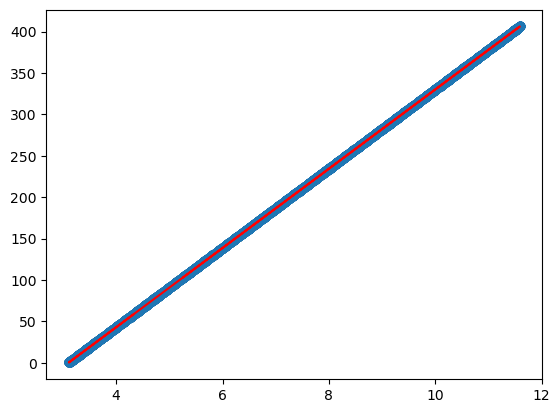

In [46]:
plt.scatter(wind_turbine_X["Wind_speed_mps"], wind_turbine_y)
plt.plot(wind_turbine_X["Wind_speed_mps"], 
         skl_model_wind_good_results.predict(wind_turbine_X),
         color='red')

### Ridge, Lasso, and Elastic Net regression

Try out these techniques now:

In [27]:
skl_ridge_wind = skl.Ridge(alpha=1.0)
skl_ridge_wind_results = skl_ridge_wind.fit(wind_turbine_X, wind_turbine_y)
skl_ridge_wind_results.coef_

C:\Users\ywang11\mambaforge\envs\ee5020\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.94459e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


array([[0.00000000e+00, 5.12651151e-12, 4.78465986e+01]])

In [28]:
skl_ridge_wind_results.intercept_

array([-148.32338923])

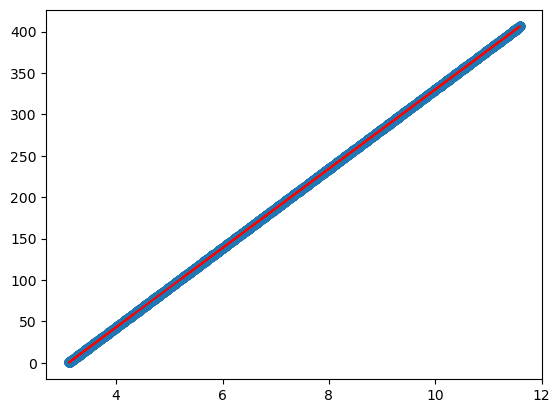

In [45]:
plt.scatter(wind_turbine_X["Wind_speed_mps"], wind_turbine_y)
plt.plot(wind_turbine_X["Wind_speed_mps"], 
         skl_ridge_wind_results.predict(wind_turbine_X),
         color='red')

In [35]:
skl_lasso_wind = skl.Lasso(alpha=1.0)
skl_lasso_wind_results = skl_lasso_wind.fit(wind_turbine_X, wind_turbine_y)
skl_lasso_wind_results.coef_

array([0.00000000e+00, 3.07729008e-09, 4.76719889e+01])

In [36]:
skl_lasso_wind_results.intercept_

array([-147.14305085])

In [53]:
skl_elasticnet_wind = skl.ElasticNet(alpha=1.0, l1_ratio=1.0)
skl_elasticnet_wind_results = skl_elasticnet_wind.fit(wind_turbine_X, wind_turbine_y)
skl_elasticnet_wind_results.coef_

array([0.00000000e+00, 3.07729008e-09, 4.76719889e+01])

In [54]:
skl_elasticnet_wind_results.intercept_

array([-147.14305085])

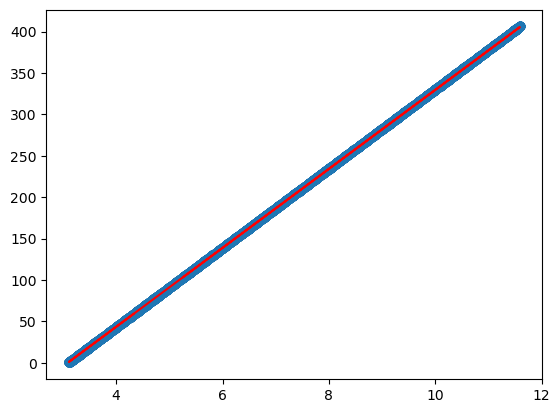

In [55]:
plt.scatter(wind_turbine_X["Wind_speed_mps"], wind_turbine_y)
plt.plot(wind_turbine_X["Wind_speed_mps"], 
         skl_elasticnet_wind_results.predict(wind_turbine_X),
         color='red')

### RANSAC Robust Regression

Sometimes, we don't really know about the outliers other than that they exist.  So we can try using RANSAC: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html

Let's try using RANSAC on the GECAD wind turbine dataset:

## Frequentist error types

Type I: false positive

Type II: false negative